# 1. Встановлення PySpark та необхідних бібліотек

In [5]:
!pip install pyspark==3.5.1

In [6]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, when
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import files

In [7]:
spark = SparkSession.builder \
    .appName("PySparkCruiseAnalysis") \
    .getOrCreate()

print("SparkSession успішно ініціалізовано.")

SparkSession успішно ініціалізовано.


# 2. Завантаження датасету "Cruise"

In [8]:
uploaded = files.upload()

Saving cruise_dataset.csv to cruise_dataset (2).csv


In [9]:
try:
    df = spark.read.csv('cruise_dataset.csv', header=True, inferSchema=True)
    print("Dataset 'cruise_dataset.csv' loaded successfully into PySpark DataFrame 'df'.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure 'cruise_dataset.csv' is in the correct path or was uploaded correctly.")

Dataset 'cruise_dataset.csv' loaded successfully into PySpark DataFrame 'df'.


# 3. Основні функції PySpark

In [10]:
df.show(5)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
only showing top 5 rows



In [11]:
df.count()

158

In [12]:
len(df.columns)

9

In [13]:
df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

In [15]:
df.select("Age", "Tonnage").show(5)

+---+------------------+
|Age|           Tonnage|
+---+------------------+
|  6|30.276999999999997|
|  6|30.276999999999997|
| 26|            47.262|
| 11|             110.0|
| 17|           101.353|
+---+------------------+
only showing top 5 rows



In [16]:
df.filter(col("Age") > 30).show(5)

+----------------+-----------+---+-------+----------+------+------+-----------------+----+
|       Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+----------------+-----------+---+-------+----------+------+------+-----------------+----+
|QueenElizabethII|     Cunard| 44| 70.327|     17.91|  9.63|   9.5|            39.27|9.21|
|          Melody|        MSC| 31| 35.143|      12.5|  6.69|  5.32|            28.11|5.35|
|        Rhapsody|        MSC| 36| 16.852|      9.52|  5.41|  3.83|             17.7|2.97|
|            Star|  Norwegian| 40|   28.0|      11.5|  6.74|   4.0|            24.35| 3.8|
|       MarcoPolo|     Orient| 48|  22.08|      8.26|  5.78|  4.25|            26.73| 3.5|
+----------------+-----------+---+-------+----------+------+------+-----------------+----+



In [18]:
df = df.withColumn("AgeCategory",
                   when(col("Age") < 18, "Child")
                   .when((col("Age") >= 18) & (col("Age") < 60), "Adult")
                   .otherwise("Senior"))
df.select("Age", "AgeCategory").show(5)

+---+-----------+
|Age|AgeCategory|
+---+-----------+
|  6|      Child|
|  6|      Child|
| 26|      Adult|
| 11|      Child|
| 17|      Child|
+---+-----------+
only showing top 5 rows



Обробка пропущених значень (приклад: заповнення середнім значенням)

In [19]:
avg_age = df.agg(avg("Age")).collect()[0][0]
print(f"\nСередній вік для заповнення пропущених значень: {avg_age:.2f}")


Середній вік для заповнення пропущених значень: 15.69


Заповнюємо пропущені значення в 'Age' середнім

In [20]:
df_filled = df.na.fill(avg_age, subset=["Age"])
print("\nКількість пропущених значень в 'Age' після заповнення:")
df_filled.filter(col("Age").isNull()).count()


Кількість пропущених значень в 'Age' після заповнення:


0

# 4. Побудова 3 графіків

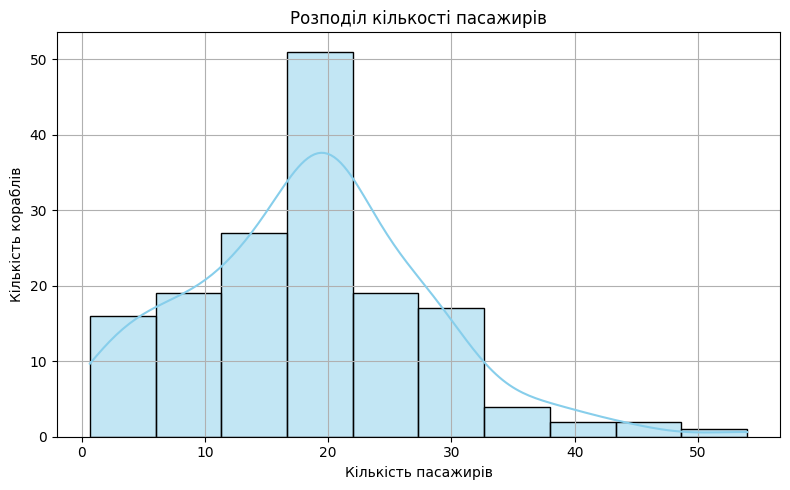

In [33]:
pdf = df.toPandas()

# Побудова гістограми
plt.figure(figsize=(8, 5))
sns.histplot(pdf['passengers'], bins=10, kde=True, color='skyblue')
plt.title('Розподіл кількості пасажирів')
plt.xlabel('Кількість пасажирів')
plt.ylabel('Кількість кораблів')
plt.grid(True)
plt.tight_layout()
plt.show()

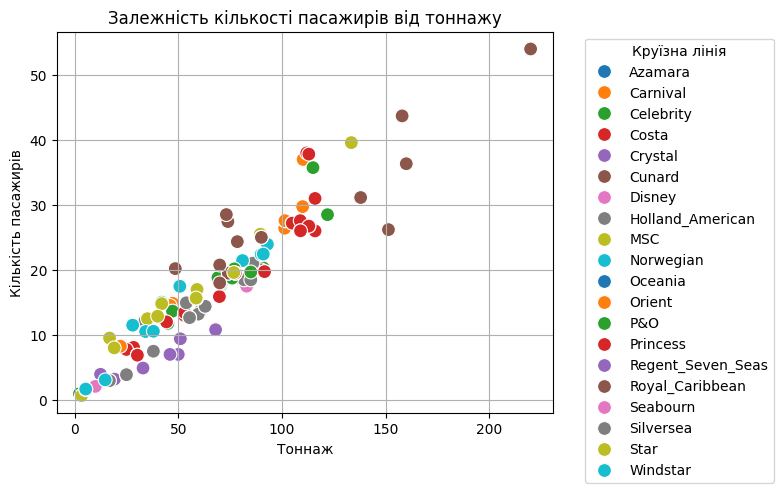

In [34]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pdf, x='Tonnage', y='passengers', hue='Cruise_line', palette='tab10', s=100)
plt.title('Залежність кількості пасажирів від тоннажу')
plt.xlabel('Тоннаж')
plt.ylabel('Кількість пасажирів')
plt.legend(title='Круїзна лінія', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-35-883f00b69399>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_passengers.values, y=avg_passengers.index, palette='viridis')


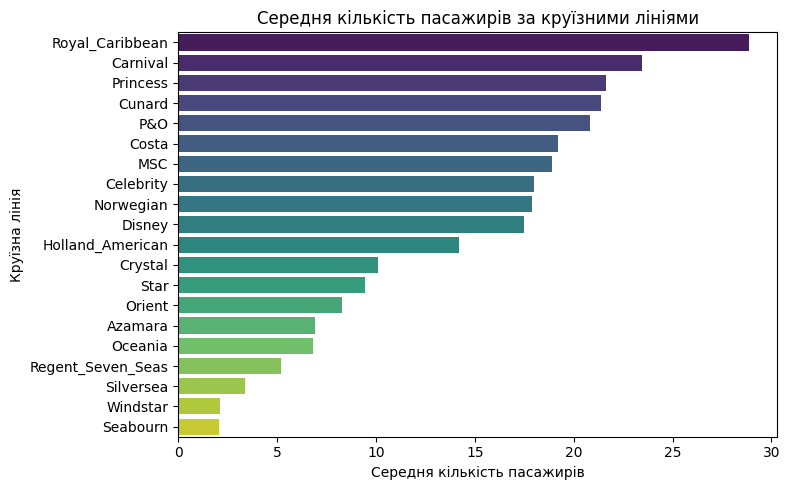

In [35]:
avg_passengers = pdf.groupby('Cruise_line')['passengers'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_passengers.values, y=avg_passengers.index, palette='viridis')
plt.title('Середня кількість пасажирів за круїзними лініями')
plt.xlabel('Середня кількість пасажирів')
plt.ylabel('Круїзна лінія')
plt.tight_layout()
plt.show()

# Висновок
Ми пройшли повний цикл аналізу даних круїзних суден, використовуючи PySpark. Спочатку ініціалізували SparkSession, що дозволило нам працювати з великими об'ємами даних у розподіленому середовищі. Потім завантажили датасет "Cruise", перевірили його схему та виконали ряд базових операцій PySpark, таких як фільтрація, групування та додавання нових стовпців. Це демонструє ефективність Spark для попередньої обробки та трансформації даних. Найважливішим кроком стало агрегування даних безпосередньо за допомогою PySpark, що дозволило нам готувати зведені таблиці для візуалізації, уникаючи проблем з пам'яттю при роботі з великими датасетами. Перший графік, гістограма, показав розподіл кількості пасажирів, виявивши типові розміри круїзних суден. Другий графік, горизонтальна барна діаграма, наочно представив середню кількість пасажирів для різних круїзних ліній, дозволяючи порівняти їхні масштаби. Нарешті, третій графік, scatter plot, візуалізував залежність кількості пасажирів від тоннажу судна, а також дозволив відстежити, як круїзні лінії розподіляються по цих параметрах, що є цінним для розуміння характеристик флоту.